In [1]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [2]:
import numpy as np

In [3]:
from distutils.command.config import config
import streamlit as st
import geopandas as gp
import pandas as pd
import plotly.express as px
import numpy as np
import math
import random
from scipy import optimize
import itertools

SIM_TYPE_RANDOMN = 'Random-N'
SIM_TYPE_TOPN = 'Top-N'
SIM_TYPE_BOTTOMN = 'Bottom-N'
SIM_TYPE_CUSTOM = 'Custom'
SIM_TYPE_SUSTAINABLE = 'Sustainable-N'

CHOICE_UTILITY = 5
ALL_COUNTRIES = "All Countries"
district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern", 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}
district_code_map_reverse = {"Bozen": 1, "Burggrafenamt": 2, "Eisacktal": 3, "Pustertal": 4, "Salten-Schlern": 5, "Uberetsch-Unterland": 6, "Vinschgau": 7, "Wipptal": 8}
DECAY_RATE = 1.2
similarities = pd.read_csv('../data/similarities_indexed.csv', index_col=0)
dataForPresences = pd.read_csv('../data/presences_simulation.csv', index_col=0)

2022-08-31 13:49:22.727 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-31 13:49:22.729 INFO    numexpr.utils: NumExpr defaulting to 8 threads.
C:\Users\gpili\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
def getK(utilities, user_choice, conv_rate):

    def func(x):
        
        total = 0
        
        for key in utilities:
            if not key == user_choice:
                total = total + math.exp(utilities[key]*x)
            
        return total - (math.exp(5)/(1 - conv_rate/100) - math.exp(5))

    sol = optimize.root_scalar(func, bracket=[0,10.], method='brentq')
    x = sol.root

    return x

def getUtilities(advertisement, userChoice, decay_rate, conv_rate = -1):

    utilities = {userChoice: CHOICE_UTILITY}

    for index, d in enumerate(advertisement):
        if not d in utilities:
            utility = similarities[str(userChoice)].loc[d]*CHOICE_UTILITY/(decay_rate**index) 
            utilities[d] = utility 
        
    if not conv_rate == -1:
        k = getK(utilities, userChoice, conv_rate)
        for key in utilities:
            if not key == userChoice:
                utilities[key] = utilities[key] * k
        
    return utilities

def getProbabilities(utilities):
    
    elSum = 0
    probabilities = {}
    
    for uKey in utilities:
        elSum = elSum + math.exp(utilities[uKey])
    
    for uKey in utilities:
        probabilities[uKey] = math.exp(utilities[uKey])/elSum
        
    return probabilities

def getSustainableForDistrict(district, k, dataframe, column):
    similaritiesToDistrict = similarities[str(district)].sort_values(ascending=False)
    sustainableItems = dataframe.sort_values(by=column, ascending=True)['district_c'].head(4).tolist()

    sustainableAd = []
    for index, row in similaritiesToDistrict.items():
        if index != district:
            if index in sustainableItems:
                sustainableAd.append(index)
            if len(sustainableAd) == k:
                return sustainableAd
    return sustainableAd

In [10]:
def getMeanAndStandardDeviation(year, month, district_c):
    filteredDf = dataForPresences[(dataForPresences["Year"] == year) & (dataForPresences["Month"] == month) & (dataForPresences["district_c"] == district_c ) ]
    filteredDf["AverageStay"] = filteredDf["Present"] / filteredDf["Arrivals"]
    filteredDf.replace([np.inf, -np.inf], 0, inplace=True)
    return [filteredDf["AverageStay"].mean(), filteredDf["AverageStay"].std()]

In [6]:
def run_sustainable(year, conv_rate, k, seen_rate, nationality_filter, decay_rate):
    
    adDictionary = {}
    utilitiesDictionary = {}
    probabilitiesDictionary = {}
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0


    if nationality_filter == ALL_COUNTRIES:

        arrivalCounts = pd.read_csv("../data/districts_ranked.csv")
        column = 'Arrivals'
    
    else:

        arrivalCounts = pd.read_csv("../data/yearly_arrivals_by_nat_and_dist.csv")
        column = nationality_filter

    ac = arrivalCounts[arrivalCounts['Year'] == year]

    for i in range(1, 9):
        adDictionary[i] = getSustainableForDistrict(i, k, ac, column)
        if not conv_rate == -1:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate, conv_rate)
        else:
            utilitiesDictionary[i] = getUtilities(adDictionary[i], i, decay_rate)

        probabilitiesDictionary[i] = getProbabilities(utilitiesDictionary[i])

    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])
    # nationalities = ['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein']

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']
    
    print(nonArrivals['Present'] )
    
    # arrivalsDf[[filter]].multiply((1-seen_rate)/100).round()


    for i, row in arrivalsDf.iterrows():

        probabilities = probabilitiesDictionary[row['district_c']]

        elements = list(probabilities.keys())
        
        choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        
        # consumedFromAdvertisement = sum(map(lambda c : c in elements, choices))
        # consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
        
        start = [row['Year'], row['Month'], row['Season']]
    
        s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]] + [nonArrivals.loc[i, "Present"]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):

            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)
            
            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    # print(df.columns.tolist())
    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()
    # print(simulatedResults.columns.tolist())

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year]
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    
    #arrivals2['sim_present'] = arrivals2['Arrivals_sim'] * 4.63335435
    
#     for 
    
#     [mean, std] = getMeanAndStandardDeviation(year, month, district_c)

    # print(arrivals2.columns.tolist())
    
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return arrivals2#[changedOpinionCount, changedOpinionCount]

    # st.session_state['comparable'] = True
    # st.session_state.nclick += 1
    # st.session_state.arrivals_sim = arrivals2
    # st.session_state.executed_simulation = st.session_state.selectbox_symtype
    # st.session_state.mode = SIMULATION
    # st.session_state.strategy = SIM_TYPE_SUSTAINABLE

In [10]:
def run_random(year, n, conv_rate, seen_rate, nationality_filter, decay_rate):

    advertisementMap = {}
    utilityMap = {}
    probabilityMap = {}
    
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0

    items = list(range(1, 9))
    
    for i in items: 
        advertisementMap[i] = {}
        elements = list(range(1, 9))
        elements.remove(i)
        for index, adCombination in enumerate(itertools.combinations(elements, n)):
            ad = list(adCombination)
            advertisementMap[i][index] = ad
        
    for i in range(1, 9):
        utilityMap[i] = {}
        probabilityMap[i] = {}
        for key in advertisementMap[i].keys():
            if not conv_rate == -1:
                utilities = getUtilities(advertisementMap[i][key], i, decay_rate, conv_rate)
            else:
                utilities = getUtilities(advertisementMap[i][key], i, decay_rate)
            utilityMap[i][key] = utilities
            probabilities = getProbabilities(utilities)
            probabilityMap[i][key] = probabilities 


    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']


    for i, row in arrivalsDf.iterrows():

        choices = []

        adNumberChoices = random.choices(list(utilityMap[row['district_c']].keys()), k = int(row['Arrivals']) )
        
        for x in range(int(row['Arrivals'])):

            adNumber = adNumberChoices[x]#random.choice(list(utilityMap[row['district_c']].keys()))
            probabilities = probabilityMap[row['district_c']][adNumber]
            elements = list(probabilities.keys())

            choice = random.choices(elements, weights=list(probabilities.values()), k=1)

            choices.append(choice[0])
        
        start = [row['Year'], row['Month'], row['Season']]

        a1 = [nonArrivals.loc[i, 'district_c']]
        a2 = [district_code_map[nonArrivals.loc[i, 'district_c']]]
        a3 = [nonArrivals.loc[i, "Arrivals"]]
        
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        consumedFromAdvertisement = sum(map(lambda c :  c != row['district_c'] or len(elements) == n, choices))
        consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
    
        s_row = pd.Series(start + a1 + a2 + a3 + [nonArrivals.loc[i, 'Present']], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):
            
            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)

            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()
   
    # print(df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).sum())

    simulatedResults.to_csv('../data/sim.csv', index=False)

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year] 
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    
    arrivals2['sim_present'] = arrivals2['Present_sim']
    
    return  [arrivals2, changedOpinionCount, consumedFromAdvertisementCount] #arrivals2 #changedOpinionCount

    # st.session_state['comparable'] = True
    # st.session_state.nclick += 1
    # st.session_state.arrivals_sim = arrivals2
    # st.session_state.executed_simulation = st.session_state.selectbox_symtype
    # st.session_state.mode = SIMULATION
    # st.session_state.strategy = SIM_TYPE_RANDOMN


In [8]:
def on_run_simulation_btn_click(year, type, n, conv_rate, seen_rate, multiselect, nationality_filter, decay_rate):

    # seen_rate = 0.6#conv_rate / 100
    
    # run advertisement
    
    changedOpinionCount = 0
    consumedFromAdvertisementCount = 0

    if nationality_filter == ALL_COUNTRIES:

        arrivalCounts = pd.read_csv("../data/districts_ranked.csv")
        ac = arrivalCounts[arrivalCounts['Year'] == year]
        
        if type == SIM_TYPE_TOPN:
            ad = ac['district_c'].head(n).tolist()
        elif type == SIM_TYPE_BOTTOMN:
            ad = ac.sort_values(by='Rank', ascending=False)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_CUSTOM:
            ad = list(map(codeLoopup, multiselect))
        else:
            ad = random.sample(range(1, 9), n)
    
    else:

        arrivalCounts = pd.read_csv("../data/yearly_arrivals_by_nat_and_dist.csv")
        ac = arrivalCounts[arrivalCounts['Year'] == year]
        
        if type == SIM_TYPE_TOPN:
            ad = ac.sort_values(by=nationality_filter, ascending=False)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_BOTTOMN:
            ad = ac.sort_values(by=nationality_filter, ascending=True)['district_c'].head(n).tolist()
        elif type == SIM_TYPE_CUSTOM:
            ad = list(map(codeLoopup, multiselect))
        else:
            ad = random.sample(range(1, 9), n)


    # setup stuff
    arrivals = pd.read_csv('../data/nationality_long.csv')
    arrivals = arrivals[arrivals['Year'] == year]

    arrivalsDf = arrivals

    # construct a new dataframe
    df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals', 'Present'])

    filter = 'Arrivals' if nationality_filter == ALL_COUNTRIES else nationality_filter

    nonArrivals = arrivalsDf.copy()
    arrivalsDf['Arrivals'] = arrivalsDf[filter].multiply(seen_rate/100).round()

    nonArrivals['Arrivals'] = nonArrivals['Arrivals'] - arrivalsDf['Arrivals']
    
    nonArrivals['Ratio'] = arrivalsDf[filter].multiply((100-seen_rate)/100).round() / arrivalsDf['Arrivals']
    
    nonArrivals['Present'] = nonArrivals['Ratio'] * arrivalsDf['Present']

    utilityMap = {}
    for index in range(1, 9):
        if not conv_rate == -1:
            utilityMap[index] = getUtilities(ad, index, decay_rate, conv_rate)
        else:
            utilityMap[index] = getUtilities(ad, index, decay_rate)


    for i, row in arrivalsDf.iterrows():

        utilities = utilityMap[row['district_c']]

        probabilities = getProbabilities(utilities)

        elements = list(probabilities.keys())
        
        choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
        
        # changedOpinion = count(c == row['district_c'] for c in choices)
        changedOpinion = sum(map(lambda c : c != row['district_c'], choices))
        changedOpinionCount = changedOpinionCount + changedOpinion
        
        consumedFromAdvertisement = sum(map(lambda c : c != row['district_c'] or len(elements) == n, choices))
        consumedFromAdvertisementCount = consumedFromAdvertisementCount + consumedFromAdvertisement
        
        # print(changedOpinion)
        # print(changedOpinionCount)
        
        start = [row['Year'], row['Month'], row['Season']]
    
        s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]] + [nonArrivals.loc[i, "Present"]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        results = getMeanAndStandardDeviation(row['Year'], row['Month'], row['district_c'])
        mean = results[0]
        std = results[1]
        
        simulatedPresences = np.random.normal(mean, std, int(row['Arrivals']))

        for dist in range(1, 9):
            
            arrivalsToDistrict = choices.count(dist)
            
            presenceArray = simulatedPresences[:arrivalsToDistrict]
            simulatedPresences = simulatedPresences[arrivalsToDistrict:]
            
            sumOfPresences = np.sum(presenceArray)

            s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [arrivalsToDistrict] + [sumOfPresences], index=df.columns)
            df = df.append(s_row,ignore_index=True)

    simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'district_c', 'District']).agg({'Arrivals': 'sum', 'Present': 'sum'}).reset_index()
   
    # print("sim: ", simulatedResults.columns)
    # print("df: ", df.columns)
    # print(df)

    simulatedResults.to_csv('../data/sim.csv', index=False)
    
    # simulatedResults

    arrivals2 = pd.read_csv('../data/nationality_trends.csv')
    arrivals2 = arrivals2[arrivals2['Year'] == year]
    arrivals2 = arrivals2.groupby(by=['Year', 'Month', 'Season', 'district_c']).sum().reset_index()

    arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c"], suffixes=("", "_sim"))
    arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
    arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
    arrivals2['sim_present'] = arrivals2['Present_sim'] #* 4.63335435
    
    return arrivals2 #[changedOpinionCount, consumedFromAdvertisementCount] #arrivals2#changedOpinionCount#(arrivals2, changedOpinionCount)

    # st.session_state['comparable'] = True
    # st.session_state.nclick += 1
    # st.session_state.arrivals_sim = arrivals2
    # st.session_state.executed_simulation = st.session_state.selectbox_symtype
    # st.session_state.mode = SIMULATION
    # st.session_state.strategy = type

In [12]:
results = {}

for n in range(1, 8):
    
    results[n] = {}
    
    for i in range(1, 6):
        
        print(n, i)
        
        results[n][i] = run_random(2019, n, -1, 100, ALL_COUNTRIES, 1.2)
        


1 1


C:\Users\gpili\AppData\Local\Temp/ipykernel_6868/2514210986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDf["AverageStay"] = filteredDf["Present"] / filteredDf["Arrivals"]


1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5
6 1
6 2
6 3
6 4
6 5
7 1
7 2
7 3
7 4
7 5


In [14]:
table = []

for n in range(1, 8):

    arrivalsSum = 0
    avgPresentSum = 0
    avgPresentPopSum = 0
    avgPresentBedSum = 0
    
    for i in range(1, 6):
        
            # print(n, i)
        
            #arrivalsSimulated = on_run_simulation_btn_click(2019, SIM_TYPE_BOTTOMN, n, -1, 100, [], ALL_COUNTRIES, 1.2)
            arrivalsSimulated = results[n][i][0]#run_random(2019, n, -1, 100, ALL_COUNTRIES, 1.2)
            #arrivalsSimulated = run_sustainable(2019, -1, n, 100, ALL_COUNTRIES, 1.2)
        
            districts = gp.read_file('../data/geo_district_df.shp')

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()

            yearlyDf = districts.merge(yearlyDf, on='district_c',
                                     how="inner", suffixes=('', '_y'))

            yearlyDf["AvgPresentSim"] = yearlyDf["sim_present"] / 365
            yearlyDf["AvgPresentToBedsSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPopSim"] = yearlyDf["AvgPresentSim"] / yearlyDf["population"]


            yearlyDf["AvgPresent"] = yearlyDf["Present"] / 365
            yearlyDf["AvgPresentToBeds"] = yearlyDf["AvgPresent"] / yearlyDf["beds"]
            yearlyDf["AvgPresentToPop"] = yearlyDf["AvgPresent"] / yearlyDf["population"]

            # #st.write(np.array(yearlyDf['avgPop'].values.tolist()))
            
            arrivals = gini_coefficient(np.array(yearlyDf['Arrivals_sim'].values.tolist()))
            avgPresent = gini_coefficient(np.array(yearlyDf['AvgPresentSim'].values.tolist()))
            avgPresentPop = gini_coefficient(np.array(yearlyDf['AvgPresentToPopSim'].values.tolist()))
            avgPresentBeds = gini_coefficient(np.array(yearlyDf['AvgPresentToBedsSim'].values.tolist()))
            
    giniArrivals = arrivalsSum / 5
    giniAvgPresent = avgPresentSum / 5
    giniAvgPresentPop = avgPresentPopSum / 5
    giniAvgPresentBed = avgPresentBedSum / 5
    
    table.append([arrivals, avgPresent, avgPresentPop, avgPresentBeds])
    
            
print(table)


[[0.2915710059509532, 0.3734549547396849, 0.3088106900962923, 0.07925915409555614], [0.28358661357432047, 0.3579457716094366, 0.2894487987158361, 0.0934933505163439], [0.28621867857895683, 0.3541085273281509, 0.2854152623617301, 0.11335961013484723], [0.28970912652550934, 0.3568630688782659, 0.28270530594434634, 0.13380101904445701], [0.2930240558793569, 0.3601990706260277, 0.27986495387042215, 0.15088195853588995], [0.2953604423081516, 0.36234842035157927, 0.27936225238151613, 0.16632339917675348], [0.29694708625507377, 0.36341044503914666, 0.27822233783046796, 0.17946262894166126]]


In [204]:
topNTable = pd.DataFrame(table, index = list(range(1, 9)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [205]:
topNTable.to_csv('../data/topN.csv')

In [207]:
bottomNTable = pd.DataFrame(table, index = list(range(1, 9)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [208]:
bottomNTable.to_csv('../data/bottomN.csv')

In [15]:
randomNTable = pd.DataFrame(table, index = list(range(1, 8)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [16]:
randomNTable.to_csv('../data/randomN.csv')

In [13]:
sustainableNTable = pd.DataFrame(table, index = list(range(1, 4)), columns =['Arrivals', 'AvgPresent', 'AvgPresentPop', 'AvgPresentBeds'])

In [14]:
sustainableNTable.to_csv('../data/sustainableN.csv')

In [18]:
# get number of all arrivals

data = pd.read_csv('../data/nationality_long.csv')
data = data[data['Year'] == 2019]
data = data.groupby(['Year']).sum().reset_index()
totalArrivals2019 = data['Arrivals'].loc[0]

totalArrivals2019

7704312.0

In [25]:
# get arrivals by real arrivals by district

averagePopularity = pd.read_csv('../data/nationality_long.csv')
averagePopularity = averagePopularity[averagePopularity['Year'] == 2019]
averagePopularity = averagePopularity.groupby(['district_c']).sum().reset_index()

averagePopularity['Popularity'] = averagePopularity['Arrivals'] / totalArrivals2019

In [19]:
table = []

for n in range(1, 8):
    
    sumArrivals = 0
    
    for i in range(1, 6):
        
            #arrivalsSimulated = on_run_simulation_btn_click(2019, SIM_TYPE_BOTTOMN, n, -1, 100, [], ALL_COUNTRIES, 1.2)
            arrivalsSimulated = results[n][i][0]#run_random(2019, n, -1, 100, ALL_COUNTRIES, 1.2)
            #arrivalsSimulated = run_sustainable(2019, -1, n, 100, ALL_COUNTRIES, 1.2)
        
            # districts = gp.read_file('../data/geo_district_df.shp')

            yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

            yearlyDf = yearlyDf.groupby(['district_c']).sum()
            
            yearlyDf['Popularity'] = yearlyDf['Arrivals'] / totalArrivals2019
            
            sumArrivals = sumArrivals + (yearlyDf['Arrivals_sim']*yearlyDf['Popularity']).sum() #np.add(arrivalsSum, np.array(yearlyDf['Arrivals_sim'].values.tolist()))

    # divider = np.empty(8)
    # divider.fill(int(5*totalArrivals2019))
    sumArrivals = sumArrivals / (5*totalArrivals2019)
    
    table.append(sumArrivals)
    
            
print(table)


[0.16759550178845709, 0.1653240462042933, 0.16503284110014382, 0.165264028866746, 0.16562148259244638, 0.1658773021887515, 0.16609935861856795]


In [43]:
sustainableNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [44]:
sustainableNTablePopularity.to_csv('../data/sustainableNPopularity.csv')

In [36]:
topNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [38]:
topNTablePopularity.to_csv('../data/topNPopularity.csv')

In [40]:
bottomNTablePopularity = pd.DataFrame(table, index = list(range(1, 9)))

In [41]:
bottomNTablePopularity.to_csv('../data/bottomNPopularity.csv')

In [20]:
randomNTablePopularity = pd.DataFrame(table, index = list(range(1, 8)))

In [21]:
randomNTablePopularity.to_csv('../data/randomNPopularity.csv')

In [22]:
table = []

for n in range(1, 8):
    
    # [changedOpinionCount, consumedFromAdvertisementCount]

    changedOpinionSum = 0
    consumedFromAdvertisementSum = 0
    
    for i in range(1, 6):
        
        #results = on_run_simulation_btn_click(2019, SIM_TYPE_BOTTOMN, n, -1, 100, [], ALL_COUNTRIES, 1.2)
        #print(changedOpinionCount)
        #results = run_random(2019, n, -1, 100, ALL_COUNTRIES, 1.2)
        #results = run_sustainable(2019, -1, n, 100, ALL_COUNTRIES, 1.2)
        changedOpinionCount = results[n][i][1] #results[0]
        consumedFromAdvertisementCount = results[n][i][2]#results[1]
            
#             print(arrivalsSimulated.columns)
        
#             districts = gp.read_file('../data/geo_district_df.shp')

#             yearlyDf = arrivalsSimulated[arrivalsSimulated['Year'] == 2019]

#             yearlyDf = yearlyDf.groupby(['Year']).sum()
            
        changedOpinionSum = changedOpinionSum + changedOpinionCount #yearlyDf['Changed'].values.tolist()[0]
        consumedFromAdvertisementSum = consumedFromAdvertisementSum + consumedFromAdvertisementCount

 
    changedRatio =changedOpinionSum / 5 / 7704312
    consumedRatio =consumedFromAdvertisementSum / 5 / 7704312
    
    # print(arrivalsSum)
    
    table.append([changedRatio, consumedRatio])
    
            
print(table)


[[0.19576592952102667, 0.19576592952102667], [0.27367232791195373, 0.27367232791195373], [0.30772546594686195, 0.30772546594686195], [0.321860770955278, 0.321860770955278], [0.32583431200605584, 0.32583431200605584], [0.32424143778185516, 0.32424143778185516], [0.31928156595942636, 0.31928156595942636]]


In [71]:
topNTableAcc = pd.DataFrame(table, index = list(range(1, 9)), columns = ["Changed", "Consumed"])

In [72]:
topNTableAcc.to_csv('../data/topNTableAcc.csv')

In [74]:
bottomNTableAcc = pd.DataFrame(table, index = list(range(1, 9)), columns = ["Changed", "Consumed"])

In [75]:
bottomNTableAcc.to_csv('../data/bottomNTableAcc.csv')

In [23]:
randomNTableAcc = pd.DataFrame(table, index = list(range(1, 8)), columns = ["Changed", "Consumed"])

In [24]:
randomNTableAcc.to_csv('../data/randomNTableAcc.csv')

In [178]:
sustainableNTableAcc = pd.DataFrame(table, index = list(range(1, 4)), columns = ["Changed", "Consumed"])

In [179]:
sustainableNTableAcc.to_csv('../data/sustainableNTableAcc.csv')

In [180]:
topNTablePopularityDf = pd.read_csv('../data/topNPopularity.csv', index_col=0)

In [183]:
topNTablePopularityDf["averagePopularity"] = topNTablePopularityDf["1"]*topNTablePopularityDf["1"] + topNTablePopularityDf["2"]*topNTablePopularityDf["2"] + topNTablePopularityDf["3"]*topNTablePopularityDf["3"] + topNTablePopularityDf["4"]*topNTablePopularityDf["4"] + topNTablePopularityDf["5"]*topNTablePopularityDf["5"] + topNTablePopularityDf["6"]*topNTablePopularityDf["6"] + topNTablePopularityDf["7"]*topNTablePopularityDf["7"] + topNTablePopularityDf["8"]*topNTablePopularityDf["8"]

In [185]:
topNTablePopularityDf.to_csv('../data/topNPopularity.csv')

In [186]:
bottomNTablePopularityDf = pd.read_csv('../data/bottomNPopularity.csv', index_col=0)

In [187]:
bottomNTablePopularityDf["averagePopularity"] = bottomNTablePopularityDf["1"]*bottomNTablePopularityDf["1"] + bottomNTablePopularityDf["2"]*bottomNTablePopularityDf["2"] + bottomNTablePopularityDf["3"]*bottomNTablePopularityDf["3"] + bottomNTablePopularityDf["4"]*bottomNTablePopularityDf["4"] + bottomNTablePopularityDf["5"]*bottomNTablePopularityDf["5"] + bottomNTablePopularityDf["6"]*bottomNTablePopularityDf["6"] + bottomNTablePopularityDf["7"]*bottomNTablePopularityDf["7"] + bottomNTablePopularityDf["8"]*bottomNTablePopularityDf["8"]

In [188]:
bottomNTablePopularityDf.to_csv('../data/bottomNPopularity.csv')

In [189]:
randomNTablePopularityDf = pd.read_csv('../data/randomNPopularity.csv', index_col=0)

In [190]:
randomNTablePopularityDf["averagePopularity"] = randomNTablePopularityDf["1"]*randomNTablePopularityDf["1"] + randomNTablePopularityDf["2"]*randomNTablePopularityDf["2"] + randomNTablePopularityDf["3"]*randomNTablePopularityDf["3"] + randomNTablePopularityDf["4"]*randomNTablePopularityDf["4"] + randomNTablePopularityDf["5"]*randomNTablePopularityDf["5"] + randomNTablePopularityDf["6"]*randomNTablePopularityDf["6"] + randomNTablePopularityDf["7"]*randomNTablePopularityDf["7"] + randomNTablePopularityDf["8"]*randomNTablePopularityDf["8"]

In [191]:
randomNTablePopularityDf.to_csv('../data/randomNPopularity.csv')

In [198]:
sustainableNTablePopularityDf = pd.read_csv('../data/sustainableNPopularity.csv', index_col=0)

In [199]:
sustainableNTablePopularityDf["averagePopularity"] = sustainableNTablePopularityDf["1"]*sustainableNTablePopularityDf["1"] + sustainableNTablePopularityDf["2"]*sustainableNTablePopularityDf["2"] + sustainableNTablePopularityDf["3"]*sustainableNTablePopularityDf["3"] + sustainableNTablePopularityDf["4"]*sustainableNTablePopularityDf["4"] + sustainableNTablePopularityDf["5"]*sustainableNTablePopularityDf["5"] + sustainableNTablePopularityDf["6"]*sustainableNTablePopularityDf["6"] + sustainableNTablePopularityDf["7"]*sustainableNTablePopularityDf["7"] + sustainableNTablePopularityDf["8"]*sustainableNTablePopularityDf["8"]

In [200]:
sustainableNTablePopularityDf.to_csv('../data/sustainableNPopularity.csv')

In [205]:
realAvgPop = np.array([590082, 1548993, 428378, 2247110, 774849, 1203473, 343777, 567650])/7704312

In [208]:
sum(list(realAvgPop * realAvgPop))

0.17638755720059165

In [218]:
arrivalsDf = pd.read_csv('../data/topN.csv', index_col=0)

In [219]:
arrivalsDf

,Arrivals,AvgPresent,AvgPresentPop,AvgPresentBeds
1,0.446276,0.446276,0.377990,0.271381
2,0.453808,0.453808,0.360898,0.277085
3,0.440243,0.440243,0.365194,0.251790
4,0.425431,0.425431,0.332722,0.232960
5,0.412779,0.412779,0.312978,0.211108
6,0.399115,0.399115,0.299117,0.185014
7,0.388409,0.388409,0.294447,0.188968
8,0.380961,0.380961,0.290412,0.212770


In [198]:
testWithPresences = on_run_simulation_btn_click(2019, SIM_TYPE_BOTTOMN, 3, -1, 100, [], ALL_COUNTRIES, 1.2)

C:\Users\gpili\AppData\Local\Temp/ipykernel_10384/2514210986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredDf["AverageStay"] = filteredDf["Present"] / filteredDf["Arrivals"]
C:\Users\gpili\anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [199]:
pd.options.display.float_format = "{:.2f}".format

In [200]:
testWithPresences

,Year,Month,Season,district_c,Arrivals,Present,District,Arrivals_sim,Present_sim,Diff,sim_present
0,2019,1.00,Winter,1,19439,42465,Bozen,28221.00,109681.60,8782.00,109681.60
1,2019,1.00,Winter,2,33810,147290,Burggrafenamt,28171.00,108411.12,-5639.00,108411.12
2,2019,1.00,Winter,3,52218,232736,Eisacktal,39617.00,216462.59,-12601.00,216462.59
3,2019,1.00,Winter,4,239602,1262370,Pustertal,207666.00,1678265.92,-31936.00,1678265.92
4,2019,1.00,Winter,5,117974,679504,Salten-Schlern,101667.00,850807.66,-16307.00,850807.66
...,...,...,...,...,...,...,...,...,...,...,...
91,2019,12.00,Winter,4,231842,926411,Pustertal,200757.00,1118881.89,-31085.00,1118881.89
92,2019,12.00,Winter,5,119580,488448,Salten-Schlern,102890.00,533297.33,-16690.00,533297.33
93,2019,12.00,Winter,6,26334,74498,Uberetsch-Unterland,64000.00,258840.98,37666.00,258840.98
94,2019,12.00,Winter,7,32771,137244,Vinschgau,23980.00,110342.35,-8791.00,110342.35


### Visualisation of Results

In [4]:
import matplotlib.pyplot as plt

In [77]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])

giniTopNDf = pd.read_csv('../data/topN.csv')
giniBottomNDf = pd.read_csv('../data/bottomN.csv')
giniRandomNDf = pd.read_csv('../data/randomN.csv')
giniSustainableNDf = pd.read_csv('../data/sustainableN.csv')

NAarray = np.repeat(None, 5)

NAarray1 = np.repeat(None, 1)

In [82]:
topNArrivals = giniTopNDf["Arrivals"][[0, 2, 4, 7]]
topNArrivals

0    0.446170
2    0.440171
4    0.412862
7    0.381183
Name: Arrivals, dtype: float64

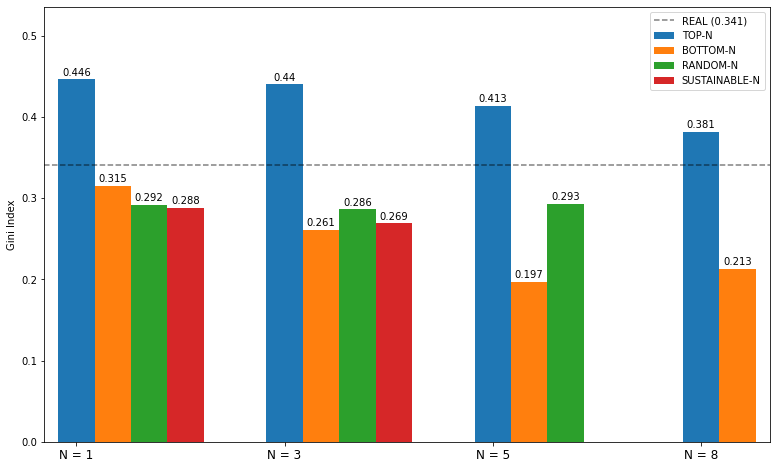

In [164]:
# GINI ARRIVALS

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 8']

topNArrivals = np.round(giniTopNDf["Arrivals"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["Arrivals"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["Arrivals"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) # giniRandomNDf["Arrivals"]
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["Arrivals"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)   #giniSustainableNDf["Arrivals"].
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, topNArrivals, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottomNArrivals, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, randomNArrivals, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sustainableNArrivals, width/4, label='SUSTAINABLE-N')

hmm = ax.axhline(0.341, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.341)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
# ax.set_title('(a) Arrivals')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)

# plt.show()
# plt.savefig('data1.png') 

# fig1 = plt.gcf()
plt.show()
# plt.draw()
# fig1.savefig('data1.png', dpi=100)

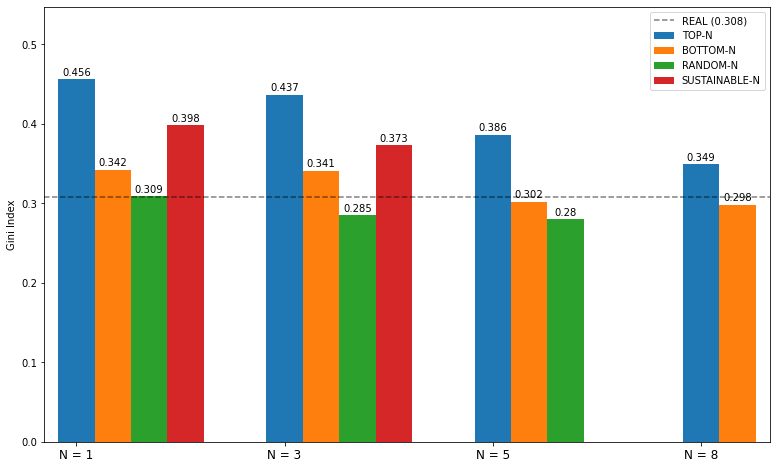

<Figure size 432x288 with 0 Axes>

In [165]:
# GINI PRES to POP

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 8']

topNArrivals = np.round(giniTopNDf["AvgPresentPop"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["AvgPresentPop"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["AvgPresentPop"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) # giniRandomNDf["Arrivals"]
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["AvgPresentPop"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)   #giniSustainableNDf["Arrivals"].
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, topNArrivals, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottomNArrivals, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, randomNArrivals, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sustainableNArrivals, width/4, label='SUSTAINABLE-N')

hmm = ax.axhline(0.30777, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.308)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
# ax.set_title('(b) Avg. Presence To Population Ratio')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('data2.png', dpi=100)

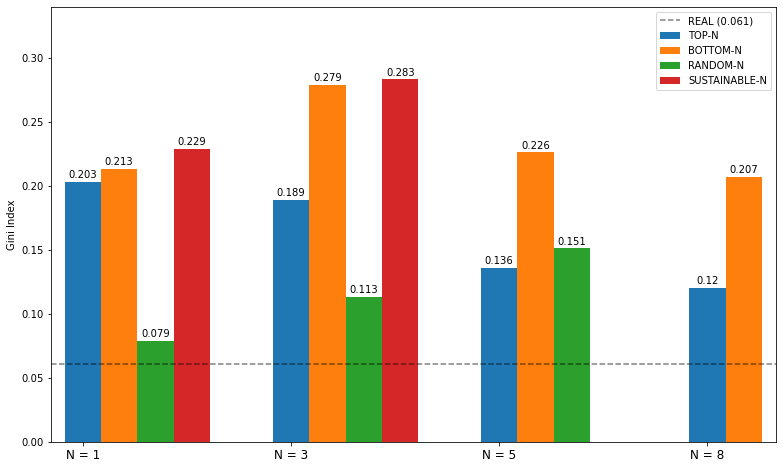

<Figure size 432x288 with 0 Axes>

In [166]:
# GINI PRES to BEDS

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 8']

topNArrivals = np.round(giniTopNDf["AvgPresentBeds"][[0, 2, 4, 7]], 3)
bottomNArrivals = np.round(giniBottomNDf["AvgPresentBeds"][[0, 2, 4, 7]], 3)
randomNArrivals = np.round(np.concatenate((giniRandomNDf["AvgPresentBeds"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3) # giniRandomNDf["Arrivals"]
sustainableNArrivals = np.round(np.concatenate((giniSustainableNDf["AvgPresentBeds"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)   #giniSustainableNDf["Arrivals"].
realityArrivals = np.repeat(0.341, 4)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, topNArrivals, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottomNArrivals, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, randomNArrivals, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sustainableNArrivals, width/4, label='SUSTAINABLE-N')

hmm = ax.axhline(0.061, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.061)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gini Index')
# ax.set_title('(c) Avg. Presence To Number of Beds Ratio')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('data3.png', dpi=100)

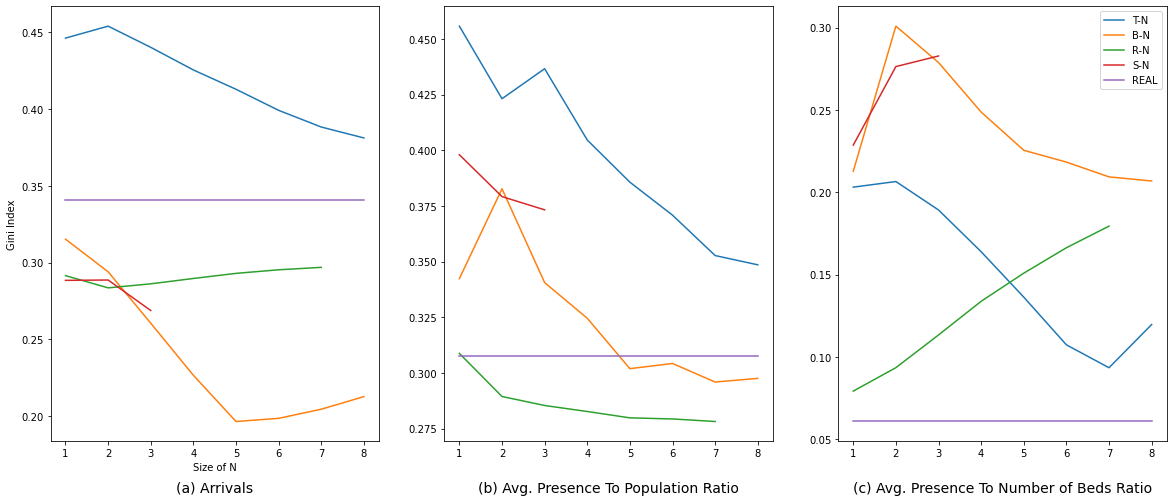

<Figure size 432x288 with 0 Axes>

In [5]:
fig = plt.figure(figsize=(20, 8))

#plot 1 - ARRIVALS:

topNArrivals = giniTopNDf["Arrivals"]
bottomNArrivals = giniBottomNDf["Arrivals"]
randomNArrivals = np.concatenate((giniRandomNDf["Arrivals"], NAarray1), axis=None) # giniRandomNDf["Arrivals"]
sustainableNArrivals = np.concatenate((giniSustainableNDf["Arrivals"], NAarray), axis=None)   #giniSustainableNDf["Arrivals"].
realityArrivals = np.repeat(0.341, 8)

fig.add_subplot(131)

plt.plot(x, topNArrivals, label='T-N')
plt.plot(x, bottomNArrivals, label='B-N')
plt.plot(x, randomNArrivals, label='R-N')
plt.plot(x, sustainableNArrivals, label='S-N')
plt.plot(x, realityArrivals, label='REAL')

plt.xlabel('Size of N')
plt.ylabel('Gini Index')

# plt.legend()

plt.title("(a) Arrivals", y=-0.13, fontsize=14)

# #plot 2 - AVG PRESENCES:

# topNAvgP = giniTopNDf["AvgPresent"]
# bottomNAvgP = giniBottomNDf["AvgPresent"]
# randomNAvgP = giniRandomNDf["AvgPresent"]
# sustainableNAvgP = np.concatenate((giniSustainableNDf["AvgPresent"], NAarray), axis=None)   #giniSustainableNDf["Arrivals"].
# realityAvgP = np.repeat(0.4027, 8)


# fig.add_subplot(142)

# plt.plot(x, topNAvgP, label='TOP')
# plt.plot(x, bottomNAvgP, label='BOT')
# plt.plot(x, randomNAvgP, label='RAND')
# plt.plot(x, sustainableNAvgP, label='SUS')
# plt.plot(x, realityAvgP, label='REAL')

# # plt.legend()

# plt.title("(b) Avg. Presences", y=-0.2, fontsize=14)

# plt.show()

#plot 3 - AVG PRESENCES POP:

topNAvgPP = giniTopNDf["AvgPresentPop"]
bottomNAvgPP = giniBottomNDf["AvgPresentPop"]
randomNAvgPP = np.concatenate((giniRandomNDf["AvgPresentPop"], NAarray1), axis=None) #giniRandomNDf["AvgPresentPop"]
sustainableNAvgPP = np.concatenate((giniSustainableNDf["AvgPresentPop"], NAarray), axis=None)   #giniSustainableNDf["Arrivals"].
realityAvgPP = np.repeat(0.30777, 8)


fig.add_subplot(132)

plt.plot(x, topNAvgPP, label='T-N')
plt.plot(x, bottomNAvgPP, label='B-N')
plt.plot(x, randomNAvgPP, label='R-N')
plt.plot(x, sustainableNAvgPP, label='S-N')
plt.plot(x, realityAvgPP, label='REAL')

# plt.xlabel('Size of N')
# plt.ylabel('Gini Index')

# plt.legend()

plt.title("(b) Avg. Presence To Population Ratio", y=-0.13, fontsize=14)

#plot 4 - AVG PRESENCES BEDS:

topNAvgPB = giniTopNDf["AvgPresentBeds"]
bottomNAvgPB = giniBottomNDf["AvgPresentBeds"]
randomNAvgPB = np.concatenate((giniRandomNDf["AvgPresentBeds"], NAarray1), axis=None) #giniRandomNDf["AvgPresentBeds"]
sustainableNAvgPB = np.concatenate((giniSustainableNDf["AvgPresentBeds"], NAarray), axis=None)   #giniSustainableNDf["Arrivals"].
realityAvgPB = np.repeat(0.0608, 8)


fig.add_subplot(133)

plt.plot(x, topNAvgPB, label='T-N')
plt.plot(x, bottomNAvgPB, label='B-N')
plt.plot(x, randomNAvgPB, label='R-N')
plt.plot(x, sustainableNAvgPB, label='S-N')
plt.plot(x, realityAvgPB, label='REAL')

# plt.xlabel('Size of N')
# plt.ylabel('Gini Index')

plt.legend()

plt.title("(c) Avg. Presence To Number of Beds Ratio", y=-0.13, fontsize=14)

plt.show()

plt.savefig('data.png') 


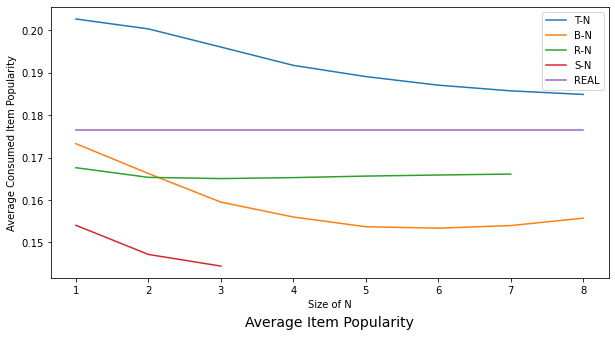

In [30]:
fig = plt.figure(figsize=(10, 5))

popTopNDf = pd.read_csv('../data/topNPopularity.csv')
popBottomNDf = pd.read_csv('../data/bottomNPopularity.csv')
popRandomNDf = pd.read_csv('../data/randomNPopularity.csv')
popSustainableNDf = pd.read_csv('../data/sustainableNPopularity.csv')

popSus = np.concatenate((popSustainableNDf["0"], NAarray), axis=None) 
popRand = np.concatenate((popRandomNDf["0"], NAarray1), axis=None) 
realityPop = np.repeat(0.1764, 8) # to change

plt.plot(x, popTopNDf["0"], label='T-N')
plt.plot(x, popBottomNDf["0"], label='B-N')
plt.plot(x, popRand, label='R-N')
plt.plot(x, popSus, label='S-N')
plt.plot(x, realityPop, label='REAL')

plt.xlabel('Size of N')
plt.ylabel('Average Consumed Item Popularity')

plt.legend()

plt.title("Average Item Popularity", y=-0.2, fontsize=14)

plt.show()

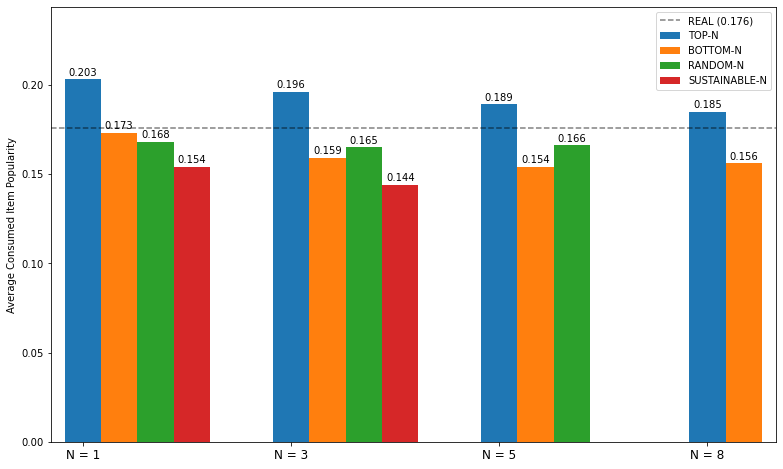

In [170]:
# POPULARITY

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 8']

popTopNDf = pd.read_csv('../data/topNPopularity.csv')
popBottomNDf = pd.read_csv('../data/bottomNPopularity.csv')
popRandomNDf = pd.read_csv('../data/randomNPopularity.csv')
popSustainableNDf = pd.read_csv('../data/sustainableNPopularity.csv')

top = np.round(popTopNDf["0"][[0, 2, 4, 7]], 3)
bottom = np.round(popBottomNDf["0"][[0, 2, 4, 7]], 3)
random = np.round(np.concatenate((popRandomNDf["0"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3)
sus = np.round(np.concatenate((popSustainableNDf["0"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, top, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottom, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, random, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sus, width/4, label='SUSTAINABLE-N')

hmm = ax.axhline(0.176, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.176)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Consumed Item Popularity')
# ax.set_title('(a) Arrivals')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.2)

# plt.show()
# plt.savefig('data1.png') 

# fig1 = plt.gcf()
plt.show()
# plt.draw()
# fig1.savefig('data1.png', dpi=100)

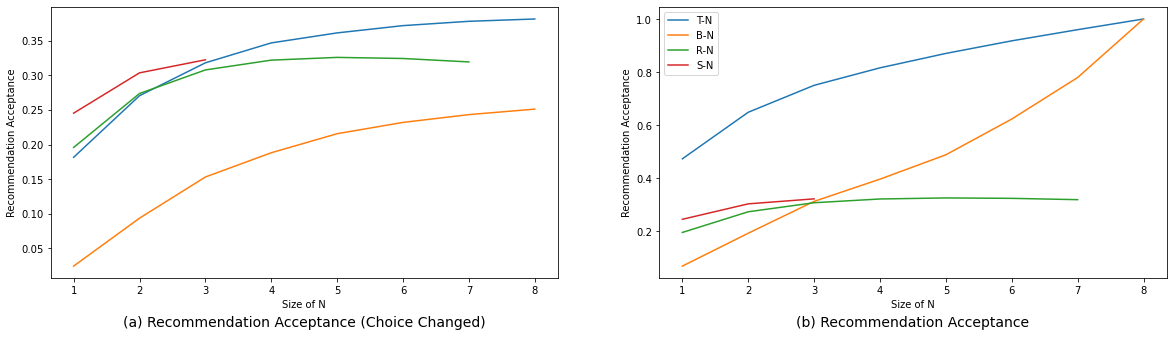

In [12]:
fig = plt.figure(figsize=(20, 5))

# Popularity 

fig.add_subplot(121)

accTopNDf = pd.read_csv('../data/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/sustainableNTableAcc.csv')

accSus = np.concatenate((accSustainableNDf["Ratio"], NAarray), axis=None) 
accRand = np.concatenate((accRandomNDf["Changed"], NAarray1), axis=None) 
realityPop = np.repeat(0.1764, 8) # to change

plt.plot(x, accTopNDf["Changed"], label='T-N')
plt.plot(x, accBottomNDf["Changed"], label='B-N')
plt.plot(x, accRand, label='R-N')
plt.plot(x, accSus, label='S-N')
# plt.plot(x, realityPop, label='REAL')

plt.xlabel('Size of N')
plt.ylabel('Recommendation Acceptance')

plt.title("(a) Recommendation Acceptance (Choice Changed)", y=-0.2, fontsize=14)

# Recommendation Acceptance

fig.add_subplot(122)

# accSus = np.concatenate((accSustainableNDf["Ratio"], NAarray), axis=None) 
# realityAvgP = np.repeat(0.1764, 8) # to change

plt.plot(x, accTopNDf["Consumed"], label='T-N')
plt.plot(x, accBottomNDf["Consumed"], label='B-N')
plt.plot(x, accRand, label='R-N')
plt.plot(x, accSus, label='S-N')

plt.xlabel('Size of N')
plt.ylabel('Recommendation Acceptance')

plt.legend()

plt.title("(b) Recommendation Acceptance", y=-0.2, fontsize=14)

plt.show()

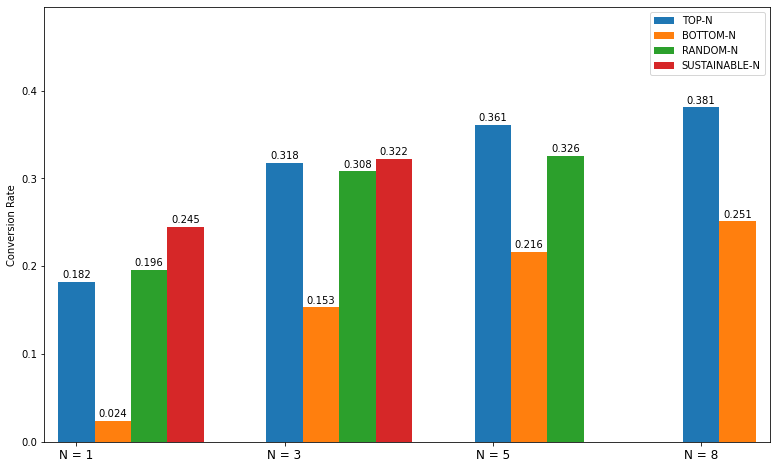

In [177]:
# REC ACC - CHOICE CHANGED

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 8']

accTopNDf = pd.read_csv('../data/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/sustainableNTableAcc.csv')

top = np.round(accTopNDf["Changed"][[0, 2, 4, 7]], 3)
bottom = np.round(accBottomNDf["Changed"][[0, 2, 4, 7]], 3)
random = np.round(np.concatenate((accRandomNDf["Changed"][[0, 2, 4]], np.array([np.NaN])), axis=None), 3)
sus = np.round(np.concatenate((accSustainableNDf["Ratio"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, top, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottom, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, random, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sus, width/4, label='SUSTAINABLE-N')

# hmm = ax.axhline(0.176, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.176)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Conversion Rate')
# ax.set_title('(a) Arrivals')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)

# plt.show()
# plt.savefig('data1.png') 

# fig1 = plt.gcf()
plt.show()
# plt.draw()
# fig1.savefig('data1.png', dpi=100)

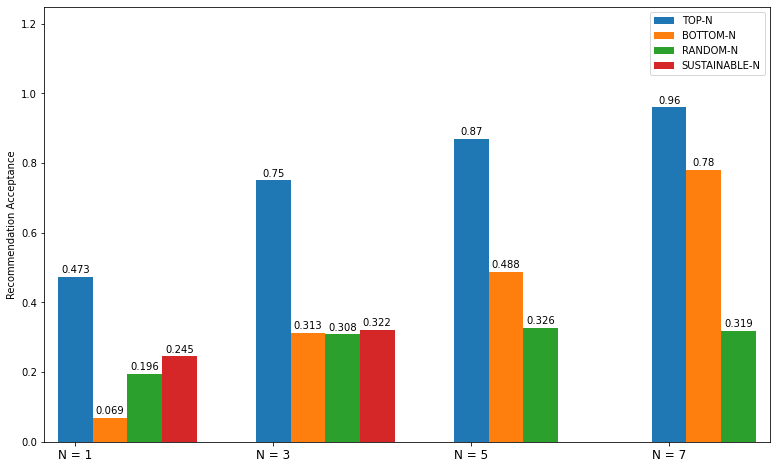

In [178]:
# REC ACC - CHOICE CHANGED

labels = ['N = 1', 'N = 3', 'N = 5', 'N = 7']

accTopNDf = pd.read_csv('../data/topNTableAcc.csv')
accBottomNDf = pd.read_csv('../data/bottomNTableAcc.csv')
accRandomNDf = pd.read_csv('../data/randomNTableAcc.csv')
accSustainableNDf = pd.read_csv('../data/sustainableNTableAcc.csv')

top = np.round(accTopNDf["Consumed"][[0, 2, 4, 6]], 3)
bottom = np.round(accBottomNDf["Consumed"][[0, 2, 4, 6]], 3)
random = np.round(accRandomNDf["Consumed"][[0, 2, 4, 6]], 3)
sus = np.round(np.concatenate((accSustainableNDf["Ratio"][[0, 2]], np.array([np.NaN, np.NaN])), axis=None), 3)

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 8))
# rects5 = ax.bar(x - 2*width/4, realityArrivals, width/4, label='REAL', color='#9566bd')
rects1 = ax.bar(x, top, width/4, label='TOP-N')
rects2 = ax.bar(x + width/4, bottom, width/4, label='BOTTOM-N')
rects3 = ax.bar(x + width/4*2, random, width/4, label='RANDOM-N')
rects4 = ax.bar(x + 3*width/4, sus, width/4, label='SUSTAINABLE-N')

# hmm = ax.axhline(0.176, color='#000000', ls='--', alpha = 0.5, label = 'REAL (0.176)')

# plt.plot([0, 1, 2, 3], [0.341, 0.341, 0.341, 0.341])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recommendation Acceptance')
# ax.set_title('(a) Arrivals')
# plt.title("(a) Arrivals", y=-0.13, fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
# ax.bar_label(rects5, padding=2)
# ax.bar_label(g, padding=3)

plt.xticks(fontsize= 12)

# fig.tight_layout()
plt.margins(0.02, 0.3)

# plt.show()
# plt.savefig('data1.png') 

# fig1 = plt.gcf()
plt.show()
# plt.draw()
# fig1.savefig('data1.png', dpi=100)